In [208]:
#Import all necessary modules
%matplotlib inline 
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
import scipy.stats as sc
import pickle

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, log_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.metrics import plot_roc_curve, hamming_loss

import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load(parse=True,tag=True,entity=True)
import re
import string
import unicodedata as unc
import unidecode as und
import contractions
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from spellchecker import SpellChecker
from gingerit.gingerit import GingerIt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim as gm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from misc_functions import *
import upsetplot as ups

In [209]:
#Read in the training data set
df_train = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/train.csv')

In [210]:
#Check first few rows
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


The data consists of six labels of which a comment may have multiple categories. Thus, this is a multi-label classification problem as shown below.

In [211]:
df_train[(df_train['toxic']==1) & (df_train['severe_toxic']==1)].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


In [212]:
#Check dataset shape
df_train.shape

(159571, 8)

In [213]:
#Check for missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


The training data does not have any missing values. Next, check distribution of labels. Initially, check comment distributions by a single label although as noted above, some are multi-labeled. Each label can be treated as a binary classification problem

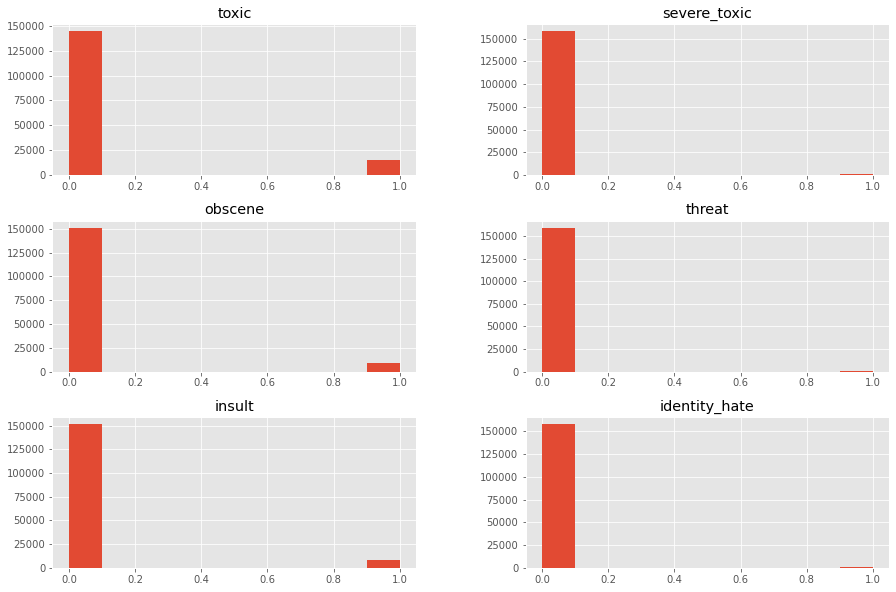

In [214]:
df_train.drop(['id','comment_text'],axis=1).hist(figsize=[15,10]);

In [215]:
df_train.drop(['id','comment_text'],axis=1).apply(lambda x: pd.Series.value_counts(x, normalize=True)*100)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,90.415552,99.000445,94.705178,99.700447,95.063639,99.119514
1,9.584448,0.999555,5.294822,0.299553,4.936361,0.880486


The dataset is imbalanced as seen above across all labels. Resampling, SMOTE ?

In [216]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [217]:
s1 = 'jalape\u00f1o'
s2 = 'jalapeño'
a = unc.normalize('NFKD',s1).encode('ascii','ignore').decode('utf-8','ignore')
b = und.unidecode(s2)

Tasks for text normalization (not in order)
Remove any tags, special characters (like accents, emoji's, etc.)
<br>lower case all the text
<br>remove numbers, special characters, punctuations, stopwords
<br>Expand contractions
<br>Stem / Lemmatize
<br>Tokenize

In [218]:
def clean_text(text):
    
    #Remove url text
    p1 = 'http\S+|https\S+|www\S+'
    text = re.sub(p1,' ',text)
    
    #Replace \n with whitespace
    p2 = '\\n?\\r'
    text = re.sub(p2,' ',text)
    
    #Replace content enclosed within brackets with whitespace
    #p3 = '\([^\)]*\)|\[[^\]]*\]|\{[^\}]*\}'
    p3 = '\(|\)|\[|\]|\{|\}|\<|\>'
    text = re.sub(p3,' ',text)
    
    #Replace any puncuations with whitespace
    punct = list(string.punctuation)
    for a in punct:
        text = text.replace(a,' ')

    #Remove any special characters except alphabetical characters and white space
    p4 = '[^a-zA-Z]|^\s'
    text = re.sub(p4,' ',text)

    #Replace multiple white spaces with single whitespace
    p5 = '\s+'
    text = re.sub(p5,' ',text)
    
    #Remove spaces at start and end of string
    p6 = '^\s|\s$'
    text = re.sub(p6,'',text)
    
    #Convert text to lower-case
    text = text.lower()
    
    return text

In [219]:
def normalizer(column):
    clean = []
    for text in column:
        #Convert accented characters to normal characters
        text = und.unidecode(text)
        
        #Expand contractions
        text = contractions.fix(text)
        
        #Apply clean_text function
        text = clean_text(text)
        #print(text)
        
        #Lemmatize text
        lem = nlp(text)
        lem_text = [token.lemma_ if token.lemma_!='-PRON-' else token.text for token in lem]
        
        #Remove stop words
        stops = [a for a in stopwords.words('english')]
        #stops = [a for a in stopwords.words('english') if a not in ["don't","no","nor","not"]]
        stp = [a for a in lem_text if a not in stops]
        
        #Join text after lemmatizing and removing stop words
        text = ' '.join(stp)
        
        clean.append(text)
    return clean

In [220]:
# df_test = df_train.copy()
# df_test['clean_text'] = normalizer(df_test['comment_text'])
# df_test['tokens'] = df_test['clean_text'].apply(word_tokenize)

In [221]:
#df_test.to_pickle('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/Cleaned Data/test.pkl')

In [222]:
unpc = pd.read_pickle('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/Cleaned Data/test.pkl')
df_test = unpc.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/Cleaned Data/test.pkl'

<AxesSubplot:xlabel='Category', ylabel='Count'>

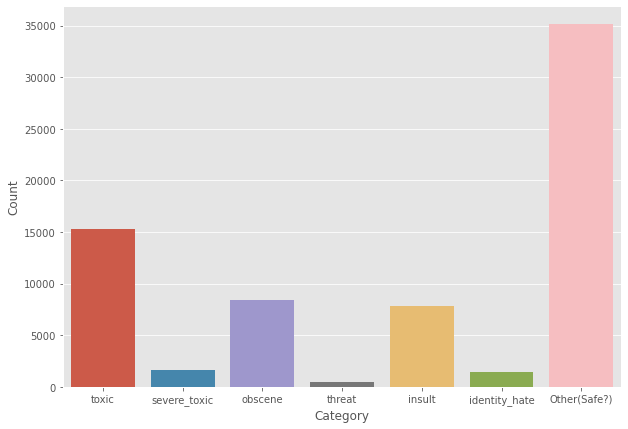

In [223]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
          'insult', 'identity_hate']
count = []
for a in labels:
    count.append((a,df_train[a].sum()))
    df_stat = pd.DataFrame(count,columns=['Category','Count'])
df_stat.loc[len(df_stat.index)] = ['Other(Safe?)', sum(df_stat['Count'])]
plt.figure(figsize=[10,7])
sns.barplot(x='Category',y='Count',data=df_stat)

Checking number of comments for each category. Majority of the comments do not belong to any of the six categories. Next, check comments with multiple labels

In [224]:
df_test['Category_Count'] = df_test.iloc[:,2:8].sum(axis=1)
df_test['none'] = (df_test[labels].max(axis=1) == 0).astype(int)

% Data without any labels:  89.83 %


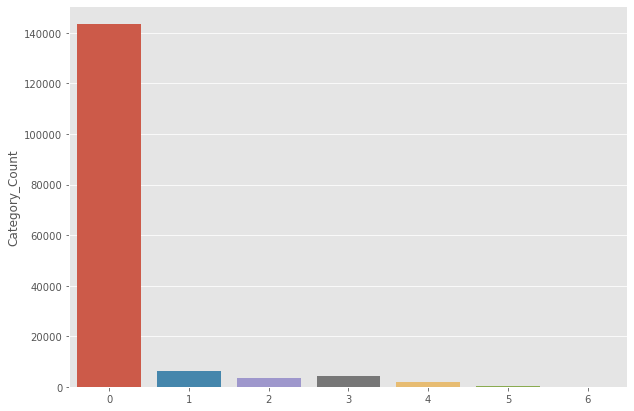

In [225]:
df_test.head()
Cat_count = df_test['Category_Count'].value_counts()
plt.figure(figsize=[10,7])
sns.barplot(x=Cat_count.index,y=Cat_count)
print('% Data without any labels: ',round((Cat_count[0]/Cat_count.sum()*100),2),'%')

Majority of the comments do not belong to any of the other five categories. Plot the bar plot without the '0' category

<AxesSubplot:ylabel='Category_Count'>

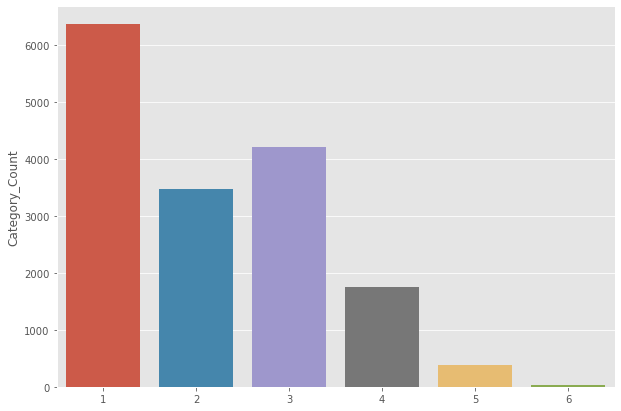

In [226]:
plt.figure(figsize=[10,7])
sns.barplot(x=Cat_count[1:].index,y=Cat_count[1:])

In [227]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,tokens,Category_Count,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edit make username hardcore metall...,"[explanation, edit, make, username, hardcore, ...",0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stick th...,"[aww, match, background, colour, seemingly, st...",0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really try edit war guy constantly rem...,"[hey, man, really, try, edit, war, guy, consta...",0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wonder sectio...,"[make, real, suggestion, improvement, wonder, ...",0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page,"[sir, hero, chance, remember, page]",0,1


In [228]:
#Check top combinations for overlapping labels
df_combination = df_test.groupby(labels).size().sort_values(ascending=False).reset_index().rename(columns={0:'Count'})
df_combination.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215


Safe comments account for the majority of comments, followed by some combinations with the label 'toxic' in the top 10 combinations

In [229]:
for a in [b for b in labels if b !='toxic']:
    count_sep = df_combination[(df_combination[a]==1)&(df_combination['toxic']==0)]['Count'].sum()
    count_both = df_combination[(df_combination[a]==1) & (df_combination['toxic']==1)]['Count'].sum()
    print('% ',a,'comments also labeled toxic: ',round((100-(count_sep/count_both)*100),2))

%  severe_toxic comments also labeled toxic:  100.0
%  obscene comments also labeled toxic:  93.4
%  threat comments also labeled toxic:  93.54
%  insult comments also labeled toxic:  92.74
%  identity_hate comments also labeled toxic:  92.09


Most comments that have other labels are also tagged as 'toxic'. All severly toxic comments are all tagged toxic.

In [230]:
#Reference: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_words(corpus, n=None,stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

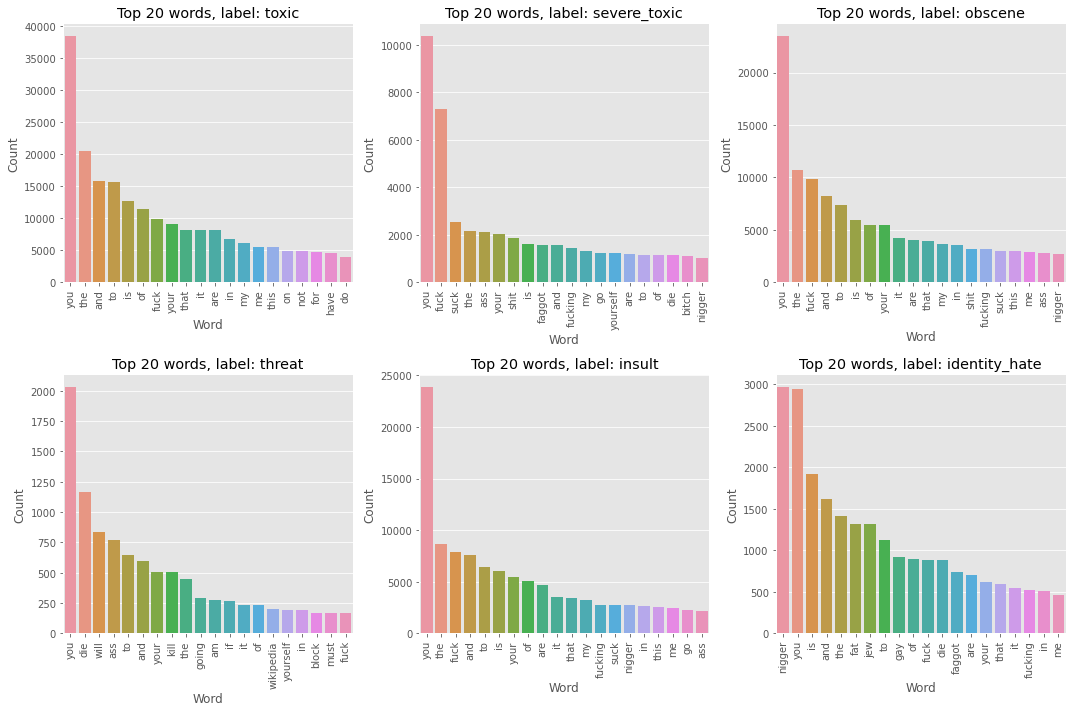

In [231]:
plt.figure(figsize=[15,10])
c=1
for a in labels:
    data = df_test[df_test[a]==1]['comment_text']
    freq_words = get_top_n_words(data,n=20)
    df_freq = pd.DataFrame(freq_words,columns=['Word','Count']).set_index('Word')
    plt.subplot(2,3,c)
    sns.barplot(x=df_freq.index,y=df_freq.Count)
    plt.title('Top 20 words, label: {}'.format(a))
    plt.xticks(rotation=90)
    c+=1
    plt.tight_layout()

The above plots are without removing stop words. Next, try with removal of stop words.

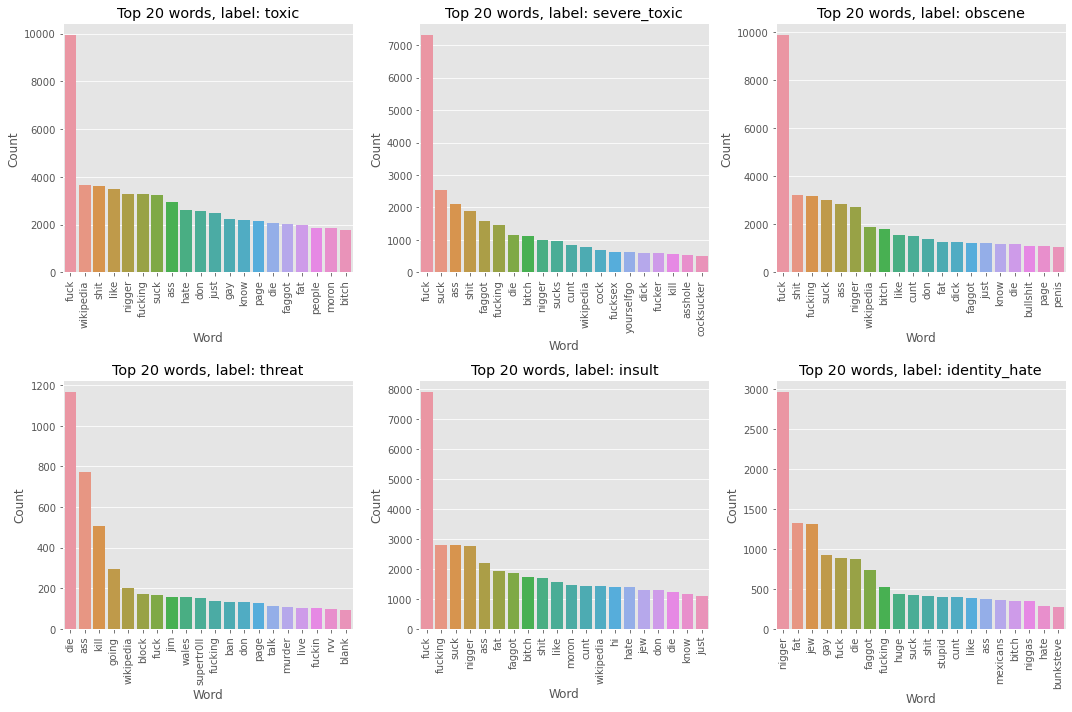

In [232]:
plt.figure(figsize=[15,10])
c=1
for a in labels:
    data = df_test[df_test[a]==1]['comment_text']
    freq_words = get_top_n_words(data,n=20,stopwords='english')
    df_freq = pd.DataFrame(freq_words,columns=['Word','Count']).set_index('Word')
    plt.subplot(2,3,c)
    sns.barplot(x=df_freq.index,y=df_freq.Count)
    plt.title('Top 20 words, label: {}'.format(a))
    plt.xticks(rotation=90)
    c+=1
    plt.tight_layout()

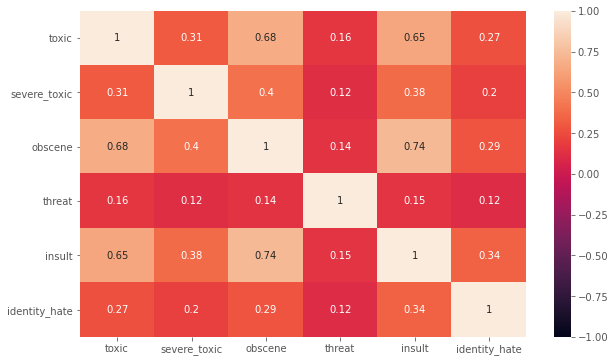

In [233]:
df_lb = df_test[labels]
plt.figure(figsize=[10,6])
sns.heatmap(df_lb.corr(),vmin=-1,vmax=1,annot=True);

In [234]:
def word_cloud(column,label):
    corpus = ' '
    for text in column:
        for token in text:
            corpus = corpus + token + ' '
    cloud = WordCloud(background_color='black',max_words=200,
                      max_font_size=70,collocations=False).generate(corpus)
    plt.figure(figsize = (12, 12))
    plt.title(label)
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.tight_layout() 

<br>Next, check word clouds for various labels. (Text can be considered profane, vulgar or offensive)

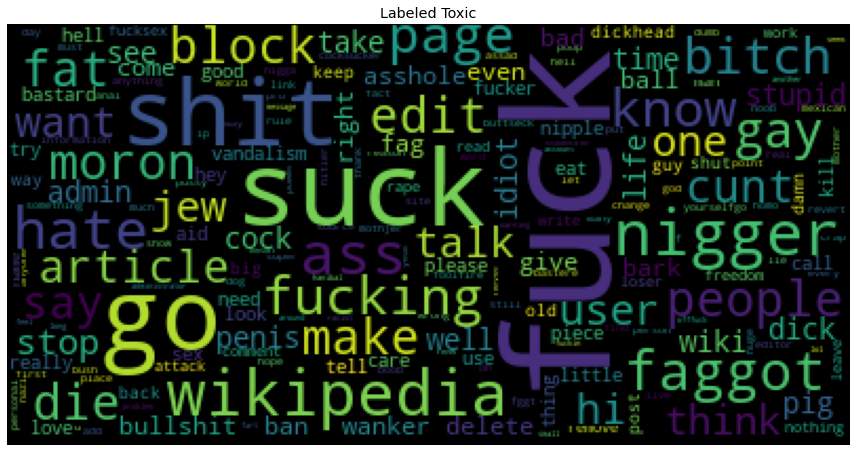

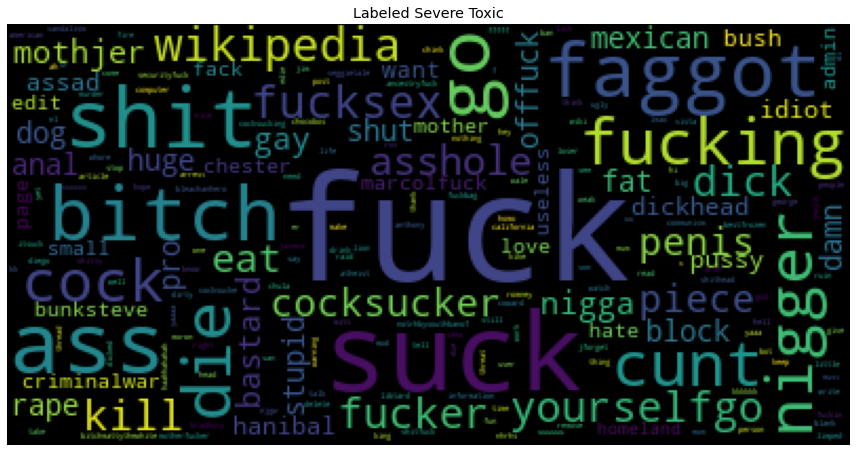

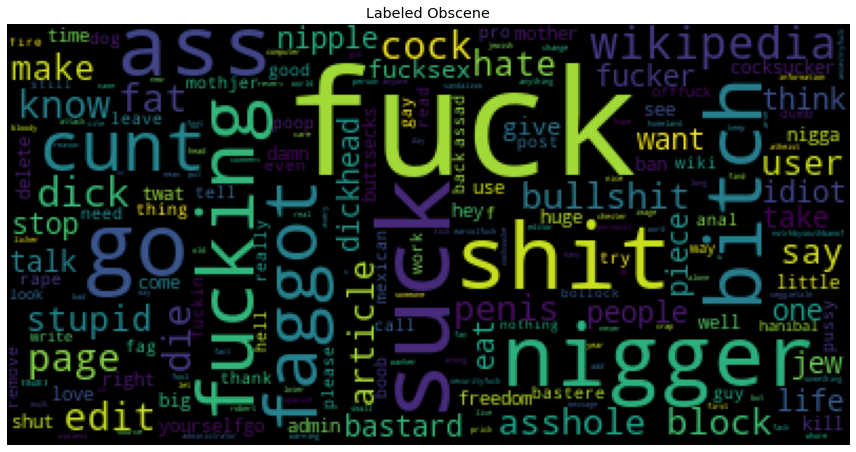

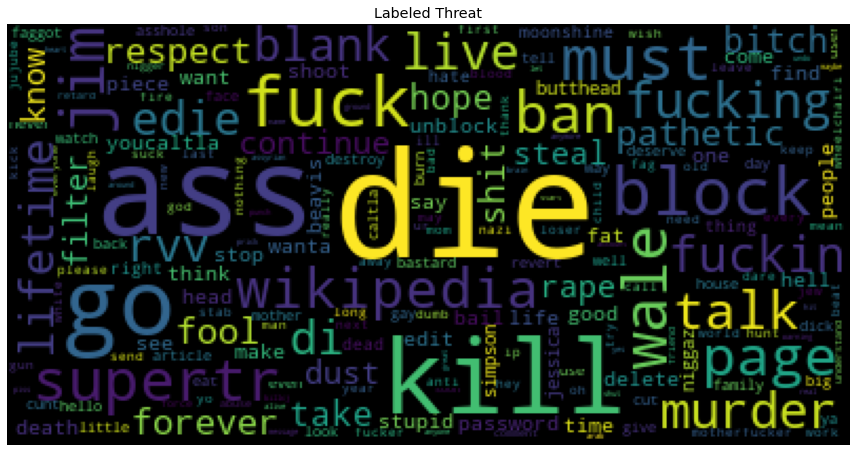

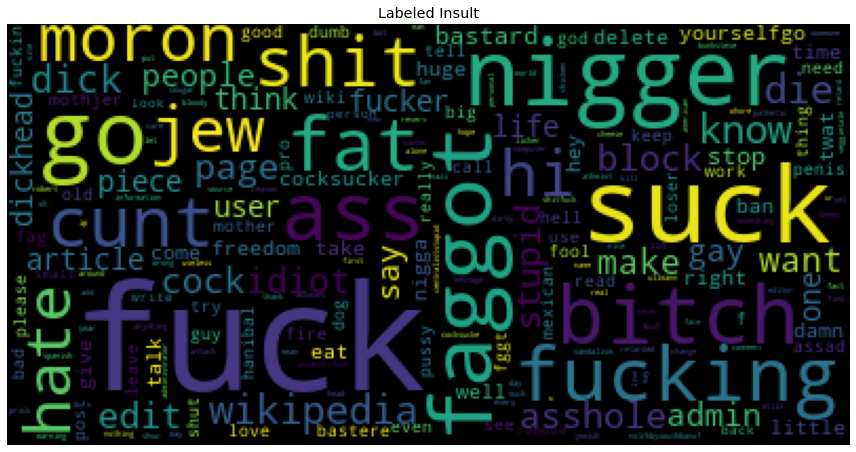

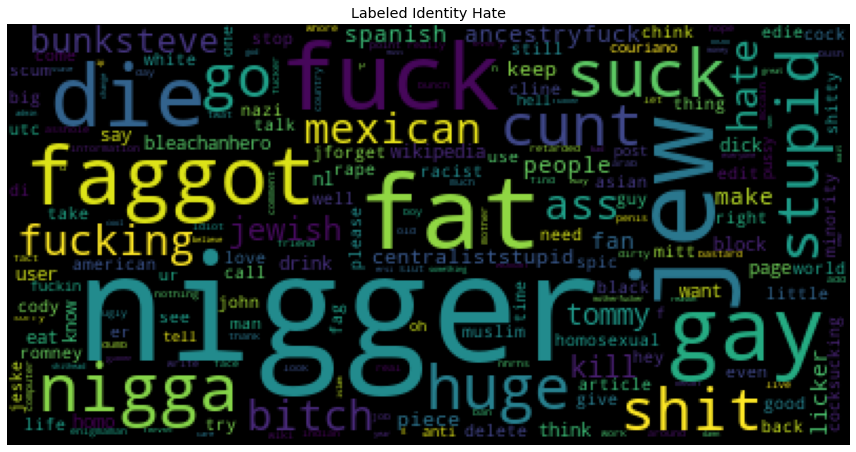

In [34]:
word_cloud(df_test[df_test['toxic']==1]['tokens'],'Labeled Toxic')
word_cloud(df_test[df_test['severe_toxic']==1]['tokens'],'Labeled Severe Toxic')
word_cloud(df_test[df_test['obscene']==1]['tokens'],'Labeled Obscene')
word_cloud(df_test[df_test['threat']==1]['tokens'],'Labeled Threat')
word_cloud(df_test[df_test['insult']==1]['tokens'],'Labeled Insult')
word_cloud(df_test[df_test['identity_hate']==1]['tokens'],'Labeled Identity Hate')

For modeling, the first approach will be to use a Count/tf-idf vectorizer coupled with/without resampling to handle imbalanced data and finally applied with models: Logistic Regression, Multinomial Naive Bayes and Light Gradient Boost

In [235]:
def vectorize(df,count=False,tfidf=False,max_f = 5000):
    if count == True:
        vect = CountVectorizer(max_features=max_f)
    elif tfidf == True:
        vect = TfidfVectorizer(max_features=max_f)
    df_nonempty = df[df['tokens'].str.len()!=0]
    X = df_nonempty[['clean_text','tokens']]
    y = df_nonempty[labels]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    train_vect = vect.fit_transform(X_train['clean_text'])
    test_vect = vect.transform(X_test['clean_text'])
    return train_vect, test_vect, y_train, y_test

In [236]:
def resample_train(X_train,y_train,undersample=False,smote=False,smote_str =0.4,undersample_str=0.5):
    from collections import Counter
    print('Pre-resampling ',Counter(y_train))
    if smote == True:
        sm = SMOTE(random_state=1,sampling_strategy=smote_str)
        #sm = SMOTE(random_state=1)
        X_train,y_train = sm.fit_resample(X_train,y_train)
        print('Oversampling (SMOTE) Class 1 = {}X Class 0 '.format(smote_str),Counter(y_train))
    if undersample == True:
        rus = RandomUnderSampler(sampling_strategy=undersample_str)
        X_train, y_train = rus.fit_resample(X_train,y_train)
        print('Undersampling Class 0 for Class 1 = {}X Class 0'.format(undersample_str),Counter(y_train))
    return X_train, y_train

In [237]:
def clf_mod(df, model,count=False,tfidf=False,resample_all=False,resample_sub=False,max_f=5000):
    auc, auc_tr = [], []
    f1, f1_tr = [], []
    #pred, tr_pred = [], []
    #pred_prob, tr_pred_prob = [], []
    Test, Test_pred, Test_prob = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for a in labels:
        
        #Vectorize 
        if count == True:
            vect = CountVectorizer(max_features=max_f)
        elif tfidf == True:
            vect = TfidfVectorizer(max_features=max_f)
            
        df_nonempty = df[df['tokens'].str.len()!=0]
        X = df_nonempty['clean_text']
        y = df_nonempty[a]
        
        #Random split into training and test data        
        X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
        X_tr = vect.fit_transform(X_tr)
        X_te = vect.transform(X_te)
        
        y_test_a = pd.DataFrame(y_te.reset_index().drop('index',axis=1))
        Test = pd.concat([Test,y_test_a],axis=1)
        
        #Resampling all or a subset of labels if True
        
        if resample_all == True:
                X_tr, y_tr = resample_train(X_train,y_train,smote=True)
        
        elif resample_sub == True:
            if a in ['severe_toxic','threat','identity_hate']:
                X_tr, y_tr = resample_train(X_train,y_train,smote=True)
        
        model.fit(X_tr.astype('float'),y_tr)
        
        y_tr_pred = model.predict(X_tr.astype('float'))
        y_tr_pred_prob = model.predict_proba(X_tr.astype('float'))
        y_te_pred = model.predict(X_te.astype('float'))
        y_te_pred_prob = model.predict_proba(X_te.astype('float'))
        
        #pred.append((a+'_test_pred',y_te_pred))
        
        pred_a = pd.DataFrame(y_te_pred).rename(columns={0:(a+'_test_pred')}).reset_index().drop('index',axis=1)
        Test_pred = pd.concat([Test_pred,pred_a],axis=1)
        
        pred_prob_a = pd.DataFrame(y_te_pred_prob).rename(columns={0:(a+'_0_prob'),1:(a+'_1_prob')}).reset_index().drop('index',axis=1)
        Test_prob = pd.concat([Test_prob,pred_prob_a],axis=1)
        
        #pred_prob.append((a+'_test_pred_prob',y_te_pred_prob))
        #tr_pred.append((a+'_train_pred',y_tr_pred))
        #tr_pred_prob.append((a+'_train_pred_prob',y_tr_pred_prob))
        
        auc_sc = roc_auc_score(y_te,y_te_pred_prob[:,1])
        f1_sc = f1_score(y_te,y_te_pred)
        auc.append(auc_sc)
        f1.append(f1_sc)
        
        auc_sc_tr = roc_auc_score(y_tr,y_tr_pred_prob[:,1])
        f1_sc_tr = f1_score(y_tr,y_tr_pred)
        auc_tr.append(auc_sc_tr)
        f1_tr.append(f1_sc_tr)
        
        print('\nLabel: ',a,', Train Set- AUC: ',round(auc_sc_tr,4),', F1: ',round(f1_sc_tr,4))
        print('Label: ',a,', Test Set- AUC: ',round(auc_sc,4),', F1: ',round(f1_sc,4))
        #model_metrics(y_te,y_te_pred,y_te_pred_prob,title=a)
    
    #predictions_test = pd.DataFrame(dict(pred))
    #predictions_prob_test = pd.DataFrame(dict(pred_prob))
    
    print('\nMean Train AUC: ',round(np.mean(auc_tr),4),'Train Macro F1: ',round(np.mean(f1_tr),4))
    print('Mean Test AUC: ',round(np.mean(auc),4),'Test Macro F1: ',round(np.mean(f1),4))
    
    print('Test Hamming Loss: ', round(hamming_loss(Test,Test_pred),4))
    print('Test Accuracy Score (Exact Match): ', round(accuracy_score(Test,Test_pred),4))
    
    

Three models will be used: Multinomial Naive Bayes, Logistic Regression and Light Gradient Boost
Initially apply count vectorizer and do not resample for all three models. A constant of 7000 max features will be used to compare models.

In [242]:
#df_test[df_test['tokens'].str.len()==0].tail(40)

In [205]:
model = MultinomialNB()
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9375 , F1:  0.7431
Label:  toxic , Test Set- AUC:  0.9281 , F1:  0.7384

Label:  severe_toxic , Train Set- AUC:  0.9696 , F1:  0.4793
Label:  severe_toxic , Test Set- AUC:  0.9496 , F1:  0.4581

Label:  obscene , Train Set- AUC:  0.9531 , F1:  0.7461
Label:  obscene , Test Set- AUC:  0.9354 , F1:  0.7146

Label:  threat , Train Set- AUC:  0.9664 , F1:  0.2639
Label:  threat , Test Set- AUC:  0.9347 , F1:  0.1983

Label:  insult , Train Set- AUC:  0.9481 , F1:  0.6769
Label:  insult , Test Set- AUC:  0.9362 , F1:  0.6611

Label:  identity_hate , Train Set- AUC:  0.9582 , F1:  0.379
Label:  identity_hate , Test Set- AUC:  0.927 , F1:  0.3435

Mean Train AUC:  0.9555 Train Macro F1:  0.5481
Mean Test AUC:  0.9352 Test Macro F1:  0.519
Test Hamming Loss:  0.0273
Test Accuracy Score (Exact Match):  0.8472


In [175]:
model = LogisticRegression(max_iter=10000)
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9811 , F1:  0.8
Label:  toxic , Test Set- AUC:  0.9511 , F1:  0.745

Label:  severe_toxic , Train Set- AUC:  0.9931 , F1:  0.5104
Label:  severe_toxic , Test Set- AUC:  0.9404 , F1:  0.3651

Label:  obscene , Train Set- AUC:  0.992 , F1:  0.8437
Label:  obscene , Test Set- AUC:  0.9616 , F1:  0.7625

Label:  threat , Train Set- AUC:  0.9948 , F1:  0.514
Label:  threat , Test Set- AUC:  0.9553 , F1:  0.2703

Label:  insult , Train Set- AUC:  0.979 , F1:  0.6738
Label:  insult , Test Set- AUC:  0.9351 , F1:  0.587

Label:  identity_hate , Train Set- AUC:  0.9831 , F1:  0.4066
Label:  identity_hate , Test Set- AUC:  0.8935 , F1:  0.1925

Mean Train AUC:  0.9872 Train Macro F1:  0.6248
Mean Test AUC:  0.9395 Test Macro F1:  0.4871
Test Hamming Loss:  0.0204
Test Accuracy Score (Exact Match):  0.8836


In [176]:
model = LGBMClassifier(learning_rate=0.075,n_estimators=500)
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9883 , F1:  0.8276
Label:  toxic , Test Set- AUC:  0.9665 , F1:  0.7624

Label:  severe_toxic , Train Set- AUC:  0.9988 , F1:  0.8677
Label:  severe_toxic , Test Set- AUC:  0.969 , F1:  0.3618

Label:  obscene , Train Set- AUC:  0.9971 , F1:  0.911
Label:  obscene , Test Set- AUC:  0.9829 , F1:  0.7977

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9776
Label:  threat , Test Set- AUC:  0.9309 , F1:  0.3382

Label:  insult , Train Set- AUC:  0.9935 , F1:  0.8257
Label:  insult , Test Set- AUC:  0.9708 , F1:  0.6925

Label:  identity_hate , Train Set- AUC:  0.999 , F1:  0.9227
Label:  identity_hate , Test Set- AUC:  0.9529 , F1:  0.3846

Mean Train AUC:  0.9961 Train Macro F1:  0.8887
Mean Test AUC:  0.9622 Test Macro F1:  0.5562
Test Hamming Loss:  0.0181
Test Accuracy Score (Exact Match):  0.8966


Next, use tf-idf vectorizer and repeat for the above models with no resampling

In [177]:
model = MultinomialNB()
clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9633 , F1:  0.6831
Label:  toxic , Test Set- AUC:  0.9599 , F1:  0.6826

Label:  severe_toxic , Train Set- AUC:  0.9775 , F1:  0.2549
Label:  severe_toxic , Test Set- AUC:  0.9711 , F1:  0.178

Label:  obscene , Train Set- AUC:  0.9726 , F1:  0.707
Label:  obscene , Test Set- AUC:  0.9624 , F1:  0.6679

Label:  threat , Train Set- AUC:  0.9339 , F1:  0.0
Label:  threat , Test Set- AUC:  0.9077 , F1:  0.0

Label:  insult , Train Set- AUC:  0.969 , F1:  0.6138
Label:  insult , Test Set- AUC:  0.9601 , F1:  0.5745

Label:  identity_hate , Train Set- AUC:  0.9632 , F1:  0.1405
Label:  identity_hate , Test Set- AUC:  0.9428 , F1:  0.087

Mean Train AUC:  0.9632 Train Macro F1:  0.3999
Mean Test AUC:  0.9507 Test Macro F1:  0.365
Test Hamming Loss:  0.0216
Test Accuracy Score (Exact Match):  0.8768


In [178]:
model = LogisticRegression(max_iter=10000)
clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9784 , F1:  0.7626
Label:  toxic , Test Set- AUC:  0.9724 , F1:  0.7461

Label:  severe_toxic , Train Set- AUC:  0.9912 , F1:  0.3571
Label:  severe_toxic , Test Set- AUC:  0.9836 , F1:  0.3841

Label:  obscene , Train Set- AUC:  0.9907 , F1:  0.7864
Label:  obscene , Test Set- AUC:  0.9835 , F1:  0.7627

Label:  threat , Train Set- AUC:  0.9934 , F1:  0.1941
Label:  threat , Test Set- AUC:  0.9833 , F1:  0.2478

Label:  insult , Train Set- AUC:  0.984 , F1:  0.6735
Label:  insult , Test Set- AUC:  0.9742 , F1:  0.6462

Label:  identity_hate , Train Set- AUC:  0.9878 , F1:  0.3573
Label:  identity_hate , Test Set- AUC:  0.9728 , F1:  0.2693

Mean Train AUC:  0.9876 Train Macro F1:  0.5219
Mean Test AUC:  0.9783 Test Macro F1:  0.5094
Test Hamming Loss:  0.0186
Test Accuracy Score (Exact Match):  0.8932


In [179]:
model = LGBMClassifier()
clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9769 , F1:  0.7753
Label:  toxic , Test Set- AUC:  0.9663 , F1:  0.7471

Label:  severe_toxic , Train Set- AUC:  0.9977 , F1:  0.6499
Label:  severe_toxic , Test Set- AUC:  0.9756 , F1:  0.2966

Label:  obscene , Train Set- AUC:  0.9946 , F1:  0.8491
Label:  obscene , Test Set- AUC:  0.9853 , F1:  0.8068

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9788
Label:  threat , Test Set- AUC:  0.9435 , F1:  0.3087

Label:  insult , Train Set- AUC:  0.9877 , F1:  0.7518
Label:  insult , Test Set- AUC:  0.9709 , F1:  0.6951

Label:  identity_hate , Train Set- AUC:  0.9985 , F1:  0.727
Label:  identity_hate , Test Set- AUC:  0.9641 , F1:  0.3416

Mean Train AUC:  0.9926 Train Macro F1:  0.7886
Mean Test AUC:  0.9676 Test Macro F1:  0.5327
Test Hamming Loss:  0.0184
Test Accuracy Score (Exact Match):  0.8949


Next, oversample the positive class (0.4 times negative class) with SMOTE and run all three models using a count vectorizer to compare across all models. Except logistic regression, the average f1 score is slightly lower with a tfidf vectorizer

In [180]:
model = MultinomialNB()
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115354, 1: 46141})

Label:  toxic , Train Set- AUC:  0.9553 , F1:  0.7445
Label:  toxic , Test Set- AUC:  0.8995 , F1:  0.7142
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126313, 1: 50525})

Label:  severe_toxic , Train Set- AUC:  0.9895 , F1:  0.8866
Label:  severe_toxic , Test Set- AUC:  0.911 , F1:  0.4129
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120830, 1: 48332})

Label:  obscene , Train Set- AUC:  0.9734 , F1:  0.8238
Label:  obscene , Test Set- AUC:  0.8923 , F1:  0.6802
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127207, 1: 50882})

Label:  threat , Train Set- AUC:  0.9909 , F1:  0.8146
Label:  threat , Test Set- AUC:  0.8603 , F1:  0.1717
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (S

In [181]:
model = LogisticRegression(max_iter=100000)
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115354, 1: 46141})

Label:  toxic , Train Set- AUC:  0.9756 , F1:  0.8857
Label:  toxic , Test Set- AUC:  0.9279 , F1:  0.6867
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126313, 1: 50525})

Label:  severe_toxic , Train Set- AUC:  0.9947 , F1:  0.9636
Label:  severe_toxic , Test Set- AUC:  0.8873 , F1:  0.2579
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120830, 1: 48332})

Label:  obscene , Train Set- AUC:  0.9881 , F1:  0.9267
Label:  obscene , Test Set- AUC:  0.929 , F1:  0.6508
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127207, 1: 50882})

Label:  threat , Train Set- AUC:  0.9966 , F1:  0.9659
Label:  threat , Test Set- AUC:  0.8423 , F1:  0.0773
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (S

In [182]:
model = LGBMClassifier()
clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115354, 1: 46141})

Label:  toxic , Train Set- AUC:  0.9602 , F1:  0.8354
Label:  toxic , Test Set- AUC:  0.9266 , F1:  0.6421
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126313, 1: 50525})

Label:  severe_toxic , Train Set- AUC:  0.991 , F1:  0.9367
Label:  severe_toxic , Test Set- AUC:  0.9434 , F1:  0.241
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120830, 1: 48332})

Label:  obscene , Train Set- AUC:  0.9811 , F1:  0.8895
Label:  obscene , Test Set- AUC:  0.9569 , F1:  0.6549
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127207, 1: 50882})

Label:  threat , Train Set- AUC:  0.9909 , F1:  0.9307
Label:  threat , Test Set- AUC:  0.8912 , F1:  0.063
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMO

Resampling seems to have caused some overfitting as indicative with the higher train and lower test set metrics. The best performing configuration so far is with a count vectorizer and without resampling. 
Light Gradient boost performs the best followed by Multinomial Naive Bayes and Logistic Regression.
Increasing the features in the vectorizer can improve the scores in addition to hyper-parameter tuning.

In [ ]:
# for n_est in [100,200,350]:
#     for lr in [0.08,0.1,0.2]:
#         for n_l in [10,31,50]:
#             mod = LGBMClassifier(n_estimators=n_est,learning_rate=lr,num_leaves=n_l)
#             clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)

In [195]:
for a in range(5000, 16000, 2000):
    print('\nVectorizer Features: ', a)
    model = LGBMClassifier()
    clf_mod(df_test,model,count=True,tfidf=False,max_f=a,resample_all=False,resample_sub=False)


Vectorizer Features:  5000

Label:  toxic , Train Set- AUC:  0.9707 , F1:  0.7546
Label:  toxic , Test Set- AUC:  0.961 , F1:  0.7356

Label:  severe_toxic , Train Set- AUC:  0.9954 , F1:  0.5925
Label:  severe_toxic , Test Set- AUC:  0.9747 , F1:  0.3785

Label:  obscene , Train Set- AUC:  0.9911 , F1:  0.8386
Label:  obscene , Test Set- AUC:  0.9835 , F1:  0.7991

Label:  threat , Train Set- AUC:  0.9997 , F1:  0.8457
Label:  threat , Test Set- AUC:  0.9272 , F1:  0.2416

Label:  insult , Train Set- AUC:  0.9837 , F1:  0.7291
Label:  insult , Test Set- AUC:  0.9693 , F1:  0.6798

Label:  identity_hate , Train Set- AUC:  0.9956 , F1:  0.6571
Label:  identity_hate , Test Set- AUC:  0.9632 , F1:  0.3855

Mean Train AUC:  0.9894 Train Macro F1:  0.7363
Mean Test AUC:  0.9632 Test Macro F1:  0.5367
Test Hamming Loss:  0.0189
Test Accuracy Score (Exact Match):  0.8916

Vectorizer Features:  7000

Label:  toxic , Train Set- AUC:  0.9713 , F1:  0.7561
Label:  toxic , Test Set- AUC:  0.9613 

KeyboardInterrupt: 

No significant changes seen with increasing feature size.  <br> Next, use pretrained word vector models word2vec and glove with Logistic Regression and Light Gradient Boost Classifier.

In [284]:
def mean_embd(model,comment,avg):
    '''
    This function takes in the pretrained word model and comment 
       tokens to create a comment vector by averaging the word vectors
       
    Words not found in the word vector model as well as empty comments
    have been replaced by an average of the word vectors in the model.
    Ref1: https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
    Ref2: https://groups.google.com/g/globalvectors/c/9w8ZADXJclA/m/hRdn4prm-XUJ
    '''
    #word_vec = [model[w] for w in comment if w in model.vocab else avg]
    #words = [word for word in comment if word in model.vocab]
    
    #Replace words not in pretained model with an average model vector
    word_vec = [model[w] if w in model.vocab else avg for w in comment]
    #Return comments that contain atleast one token
    if len(word_vec)>=1:
        return np.mean(word_vec,axis=0)
    #    return np.mean(model[words],axis=0)
    else:
        #Return average model vector if comment is empty
        return avg
    
def create_features(df,model,avg):
    '''
    This function takes in the dataframe and word model (glove or word2vec) 
    to return mean embeddings for each comment.
    '''
    df_X = df['tokens'].apply(lambda a: mean_embd(model,a,avg))
    X = pd.DataFrame(dict(zip(df_X.index,df_X.values))).T
    print(X.isna().any(axis=1).sum())
    print(X.shape, X.dropna().shape)
    y_all = df[labels]
    y_all = pd.concat([X,y_all],axis=1).dropna()[labels]
    X = X.dropna()
    return X, y_all

In [249]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d.txt'
# w2v_output = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d_w2v.txt'
# glove2word2vec(glove_input,w2v_output)

# #Load pretrained glove model
# file = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d_w2v.txt'
# mod_glove = gm.models.KeyedVectors.load_word2vec_format(file, binary=False)

# #Load pretrained word2vec model
# mod_w2v = gm.models.KeyedVectors.load_word2vec_format('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/GoogleNews-vectors-negative300.bin', binary=True) 

# # #Save models for later use
# gl_p = gm.utils.SaveLoad.save(mod_glove,'glove_300')
# w2v_p = gm.utils.SaveLoad.save(mod_w2v,'w2v_300')
# gl_p = mod_glove.save('glove_300.pkl')
# w2v_p = mod_w2v.save('w2v_300.pkl')

#Averaged vector of all vocabulary in word2vec and glove to replace unknown words and empty comments in the corpus
avgvec_gl = np.mean([mod_glove[w] for w in mod_glove.vocab],axis=0)
avgvec_w2v = np.mean([mod_w2v[w] for w in mod_w2v.vocab],axis=0)

In [186]:
def clf_mod_emb(X,y_all,model,resample_all=False,resample_sub=False):
    auc, auc_tr = [], []
    f1, f1_tr = [], []
    #pred, tr_pred = [], []
    #pred_prob, tr_pred_prob = [], []
    Test, Test_pred, Test_prob = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for a in labels:
        
        y = y_all[a]
        #Random split into training and test data
        X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
        
        y_test_a = pd.DataFrame(y_te.reset_index().drop('index',axis=1))
        Test = pd.concat([Test,y_test_a],axis=1)
        
        #Resampling all or a subset of labels if True
        if resample_all == True:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True,undersample=False)
        
        elif resample_sub == True:
            if a in ['severe_toxic','threat','identity_hate']:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True)
        
        model.fit(X_tr.astype('float'),y_tr)
        
        y_tr_pred = model.predict(X_tr.astype('float'))
        y_tr_pred_prob = model.predict_proba(X_tr.astype('float'))
        y_te_pred = model.predict(X_te.astype('float'))
        y_te_pred_prob = model.predict_proba(X_te.astype('float'))
        
        #pred.append((a+'_test_pred',y_te_pred))
        
        pred_a = pd.DataFrame(y_te_pred).rename(columns={0:(a+'_test_pred')}).reset_index().drop('index',axis=1)
        Test_pred = pd.concat([Test_pred,pred_a],axis=1)
        
        pred_prob_a = pd.DataFrame(y_te_pred_prob).rename(columns={0:(a+'_0_prob'),1:(a+'_1_prob')}).reset_index().drop('index',axis=1)
        Test_prob = pd.concat([Test_prob,pred_prob_a],axis=1)
        
        #pred_prob.append((a+'_test_pred_prob',y_te_pred_prob))
        #tr_pred.append((a+'_train_pred',y_tr_pred))
        #tr_pred_prob.append((a+'_train_pred_prob',y_tr_pred_prob))
        
        auc_sc = roc_auc_score(y_te,y_te_pred_prob[:,1])
        f1_sc = f1_score(y_te,y_te_pred)
        auc.append(auc_sc)
        f1.append(f1_sc)
        
        auc_sc_tr = roc_auc_score(y_tr,y_tr_pred_prob[:,1])
        f1_sc_tr = f1_score(y_tr,y_tr_pred)
        auc_tr.append(auc_sc_tr)
        f1_tr.append(f1_sc_tr)
        
        print('\nLabel: ',a,', Train Set- AUC: ',round(auc_sc_tr,4),', F1: ',round(f1_sc_tr,4))
        print('Label: ',a,', Test Set- AUC: ',round(auc_sc,4),', F1: ',round(f1_sc,4))
        #model_metrics(y_te,y_te_pred,y_te_pred_prob,title=a)
    
    print('\nMean Train AUC: ',round(np.mean(auc_tr),4),'Train Macro F1: ',round(np.mean(f1_tr),4))
    print('Mean Test AUC: ',round(np.mean(auc),4),'Test Macro F1: ',round(np.mean(f1),4))
    print('Test Hamming Loss: ', round(hamming_loss(Test,Test_pred),4))
    print('Test Accuracy Score (Exact Match): ', round(accuracy_score(Test,Test_pred),4))

Create average comment vectors using word2vec and glove models

In [276]:
# mod_glove = gm.utils.SaveLoad.load('glove_300')
# mod_w2v = gm.utils.SaveLoad.load('w2v_300')
X_glove, y_all_glove = create_features(df_test,mod_glove,avgvec_gl)
X_w2v, y_all_w2v = create_features(df_test,mod_w2v,avgvec_w2v)

0
(159571, 300) (159571, 300)
0
(159571, 300) (159571, 300)


Running models Logistic Regression and Light Gradient Boost with word2vec and glove averaged vectors with/without resampling

In [274]:
#Word2Vec Embedding without resampling
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9531 , F1:  0.6531
Label:  toxic , Test Set- AUC:  0.956 , F1:  0.6558

Label:  severe_toxic , Train Set- AUC:  0.979 , F1:  0.2893
Label:  severe_toxic , Test Set- AUC:  0.9775 , F1:  0.3243

Label:  obscene , Train Set- AUC:  0.968 , F1:  0.6584
Label:  obscene , Test Set- AUC:  0.967 , F1:  0.6496

Label:  threat , Train Set- AUC:  0.977 , F1:  0.1565
Label:  threat , Test Set- AUC:  0.9637 , F1:  0.15

Label:  insult , Train Set- AUC:  0.9608 , F1:  0.5224
Label:  insult , Test Set- AUC:  0.9565 , F1:  0.5113

Label:  identity_hate , Train Set- AUC:  0.9644 , F1:  0.2214
Label:  identity_hate , Test Set- AUC:  0.958 , F1:  0.1739

Mean Train AUC:  0.9671 Train Macro F1:  0.4169
Mean Test AUC:  0.9631 Test Macro F1:  0.4108
Test Hamming Loss:  0.0243
Test Accuracy Score (Exact Match):  0.8626


In [277]:
#Word2Vec Embedding with resampling
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9581 , F1:  0.8089
Label:  toxic , Test Set- AUC:  0.9567 , F1:  0.6915
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9835 , F1:  0.8935
Label:  severe_toxic , Test Set- AUC:  0.9803 , F1:  0.3267
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9726 , F1:  0.8475
Label:  obscene , Test Set- AUC:  0.9683 , F1:  0.6513
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9841 , F1:  0.9067
Label:  threat , Test Set- AUC:  0.9606 , F1:  0.1046
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (

In [278]:
#Word2Vec Embedding without resampling
model = LGBMClassifier()
clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9782 , F1:  0.7592
Label:  toxic , Test Set- AUC:  0.9577 , F1:  0.697

Label:  severe_toxic , Train Set- AUC:  0.9999 , F1:  0.9598
Label:  severe_toxic , Test Set- AUC:  0.9819 , F1:  0.3124

Label:  obscene , Train Set- AUC:  0.995 , F1:  0.8221
Label:  obscene , Test Set- AUC:  0.9725 , F1:  0.7116

Label:  threat , Train Set- AUC:  0.9701 , F1:  0.8832
Label:  threat , Test Set- AUC:  0.8138 , F1:  0.1394

Label:  insult , Train Set- AUC:  0.9922 , F1:  0.7472
Label:  insult , Test Set- AUC:  0.9606 , F1:  0.6042

Label:  identity_hate , Train Set- AUC:  0.9999 , F1:  0.9775
Label:  identity_hate , Test Set- AUC:  0.9578 , F1:  0.2823

Mean Train AUC:  0.9892 Train Macro F1:  0.8582
Mean Test AUC:  0.9407 Test Macro F1:  0.4578
Test Hamming Loss:  0.0234
Test Accuracy Score (Exact Match):  0.8672


In [279]:
#Word2Vec Embedding with resampling (ADDED average model vector for unknown and empty comments)
model = LGBMClassifier()
clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9838 , F1:  0.8887
Label:  toxic , Test Set- AUC:  0.955 , F1:  0.7041
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9989 , F1:  0.985
Label:  severe_toxic , Test Set- AUC:  0.9845 , F1:  0.4469
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9952 , F1:  0.9421
Label:  obscene , Test Set- AUC:  0.9703 , F1:  0.7112
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9973
Label:  threat , Test Set- AUC:  0.9653 , F1:  0.3789
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SMOTE

In [280]:
#Glove Embedding without resampling
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9431 , F1:  0.6313
Label:  toxic , Test Set- AUC:  0.9473 , F1:  0.6379

Label:  severe_toxic , Train Set- AUC:  0.9781 , F1:  0.286
Label:  severe_toxic , Test Set- AUC:  0.9743 , F1:  0.3216

Label:  obscene , Train Set- AUC:  0.9623 , F1:  0.6584
Label:  obscene , Test Set- AUC:  0.96 , F1:  0.652

Label:  threat , Train Set- AUC:  0.9735 , F1:  0.1771
Label:  threat , Test Set- AUC:  0.9637 , F1:  0.1613

Label:  insult , Train Set- AUC:  0.9552 , F1:  0.5159
Label:  insult , Test Set- AUC:  0.953 , F1:  0.5124

Label:  identity_hate , Train Set- AUC:  0.9646 , F1:  0.2394
Label:  identity_hate , Test Set- AUC:  0.9612 , F1:  0.2271

Mean Train AUC:  0.9628 Train Macro F1:  0.418
Mean Test AUC:  0.9599 Test Macro F1:  0.4187
Test Hamming Loss:  0.0246
Test Accuracy Score (Exact Match):  0.8609


In [191]:
#Glove Embedding without resampling
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9439 , F1:  0.6388
Label:  toxic , Test Set- AUC:  0.942 , F1:  0.6303

Label:  severe_toxic , Train Set- AUC:  0.9773 , F1:  0.2819
Label:  severe_toxic , Test Set- AUC:  0.9734 , F1:  0.2766

Label:  obscene , Train Set- AUC:  0.9614 , F1:  0.6636
Label:  obscene , Test Set- AUC:  0.959 , F1:  0.6488

Label:  threat , Train Set- AUC:  0.973 , F1:  0.1717
Label:  threat , Test Set- AUC:  0.9624 , F1:  0.1356

Label:  insult , Train Set- AUC:  0.9547 , F1:  0.524
Label:  insult , Test Set- AUC:  0.9516 , F1:  0.5014

Label:  identity_hate , Train Set- AUC:  0.9646 , F1:  0.2427
Label:  identity_hate , Test Set- AUC:  0.9513 , F1:  0.1676

Mean Train AUC:  0.9625 Train Macro F1:  0.4205
Mean Test AUC:  0.9566 Test Macro F1:  0.3934
Test Hamming Loss:  0.025
Test Accuracy Score (Exact Match):  0.8583


In [283]:
#Glove Embedding with resampling
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_glove,y_all_glove,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9488 , F1:  0.7845
Label:  toxic , Test Set- AUC:  0.9478 , F1:  0.664
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9824 , F1:  0.891
Label:  severe_toxic , Test Set- AUC:  0.9782 , F1:  0.3114
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.968 , F1:  0.834
Label:  obscene , Test Set- AUC:  0.9616 , F1:  0.6341
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9813 , F1:  0.8876
Label:  threat , Test Set- AUC:  0.9635 , F1:  0.1014
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SMOT

In [281]:
#Glove Embedding without resampling
model = LGBMClassifier()
clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9733 , F1:  0.7371
Label:  toxic , Test Set- AUC:  0.9471 , F1:  0.6657

Label:  severe_toxic , Train Set- AUC:  0.9999 , F1:  0.956
Label:  severe_toxic , Test Set- AUC:  0.9774 , F1:  0.3364

Label:  obscene , Train Set- AUC:  0.9936 , F1:  0.8061
Label:  obscene , Test Set- AUC:  0.9657 , F1:  0.7029

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9896
Label:  threat , Test Set- AUC:  0.9018 , F1:  0.144

Label:  insult , Train Set- AUC:  0.9908 , F1:  0.7357
Label:  insult , Test Set- AUC:  0.9566 , F1:  0.5866

Label:  identity_hate , Train Set- AUC:  1.0 , F1:  0.9861
Label:  identity_hate , Test Set- AUC:  0.9667 , F1:  0.2768

Mean Train AUC:  0.9929 Train Macro F1:  0.8684
Mean Test AUC:  0.9525 Test Macro F1:  0.4521
Test Hamming Loss:  0.0235
Test Accuracy Score (Exact Match):  0.866


In [282]:
#Glove Embedding with resampling
model = LGBMClassifier()
clf_mod_emb(X_glove,y_all_glove,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9794 , F1:  0.8745
Label:  toxic , Test Set- AUC:  0.9441 , F1:  0.6781
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9988 , F1:  0.984
Label:  severe_toxic , Test Set- AUC:  0.9826 , F1:  0.4484
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9941 , F1:  0.9366
Label:  obscene , Test Set- AUC:  0.9672 , F1:  0.6978
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9999 , F1:  0.9965
Label:  threat , Test Set- AUC:  0.9614 , F1:  0.381
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SM

The count/tfidf vectorizer based models perform better in terms of the evaulation metrics compared against word2vec/glove averaged embeddings based models.
<br>Logistic Regression without resampling performs better than Light Gradient Boosting.
<br>Light Gradient Boost seems to show more overfitting based on individual auc and f1 scores compared to Logistic Regression
<br>Performances are similar between the two word embeddings.
<br>Next, hyper parameter tuning for Light Gradient Boost with word2vec with changes to resampling fractions as well

In [201]:
model = LogisticRegression(max_iter=100000)
clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.955 , F1:  0.6611
Label:  toxic , Test Set- AUC:  0.953 , F1:  0.6595

Label:  severe_toxic , Train Set- AUC:  0.9791 , F1:  0.2875
Label:  severe_toxic , Test Set- AUC:  0.976 , F1:  0.2628

Label:  obscene , Train Set- AUC:  0.9679 , F1:  0.657
Label:  obscene , Test Set- AUC:  0.9654 , F1:  0.6631

Label:  threat , Train Set- AUC:  0.9734 , F1:  0.1634
Label:  threat , Test Set- AUC:  0.981 , F1:  0.1754

Label:  insult , Train Set- AUC:  0.9607 , F1:  0.5297
Label:  insult , Test Set- AUC:  0.9584 , F1:  0.5123

Label:  identity_hate , Train Set- AUC:  0.9629 , F1:  0.2216
Label:  identity_hate , Test Set- AUC:  0.9607 , F1:  0.204

Mean Train AUC:  0.9665 Train Macro F1:  0.42
Mean Test AUC:  0.9657 Test Macro F1:  0.4129
Test Hamming Loss:  0.024
Test Accuracy Score (Exact Match):  0.8645


In [105]:
for n_est in [100,200,350]:
    for lr in [0.08,0.1,0.2]:
        for n_l in [10,31,50]:
            mod = LGBMClassifier(n_estimators=n_est,learning_rate=lr,num_leaves=n_l)
            clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)

In [309]:
def vectorize(df,count=False,tfidf=False,max_f = 5000):
    if count == True:
        vect = CountVectorizer(max_features=max_f)
    elif tfidf == True:
        vect = TfidfVectorizer(max_features=max_f)
    df_nonempty = df[df['tokens'].str.len()!=0]
    X = df_nonempty[['clean_text','tokens']]
    y = df_nonempty[labels]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    train_vect = vect.fit_transform(X_train['clean_text'])
    test_vect = vect.transform(X_test['clean_text'])
    return train_vect, test_vect, y_train, y_test

X_train, X_test, y_train, y_test = vectorize(df_test,count=True,tfidf=False,max_f=None)